In [3]:
import jax
import jax.numpy as jnp
from jax import random

import numpy as np
from flax import nnx
import optax
import polars as pl
import matplotlib.pyplot as plt

from absl import logging

logging.set_verbosity(logging.INFO)

import os
import dataclasses

In [4]:
class InputModel(nnx.Module):
    def __init__(self, birth=100.0, death=1.0, dt=1e-2, rngs: nnx.Rngs | None = None):
        self.birth = birth
        self.death = death
        self.dt = dt
        self.rngs = rngs

    def initial_state(self, s: jax.Array, generate=False, rngs: nnx.Rngs | None = None):
        mu = self.birth / self.death

        if rngs is None and self.rngs is not None:
            rng = self.rngs["input"]
        else:
            rng = rngs

        if generate:
            if rng is None:
                raise ValueError("Need to provide rng for generating.")
            s0 = random.normal(rng(), s.shape[:-1]) * jnp.sqrt(mu)
            key = rng()
        else:
            s0 = s[..., 0]
            key = None

        logp_init = jax.scipy.stats.norm.logpdf(s0, scale=jnp.sqrt(mu))
        return (key, logp_init, s0)

    def step(self, carry: tuple[jax.Array | None, jax.Array, jax.Array], s: jax.Array):
        key, logp, s_prev = carry
        sigma = jnp.sqrt(2 * self.birth * self.dt)
        mu = self.birth / self.death
        ds = self.dt * (self.birth - self.death * (s_prev + mu))
        if key is not None:
            key, next_key = random.split(key)
            s = s_prev + ds + sigma * random.normal(key, s.shape)
        else:
            next_key = None
        logp += jax.scipy.stats.norm.logpdf(s - (s_prev + ds), scale=sigma)
        return (next_key, logp, s), (s if key is not None else None)

    def __call__(self, s: jax.Array, generate=False, rngs: nnx.Rngs | None = None):
        init_state = self.initial_state(s, generate=generate, rngs=rngs)
        (_, logp, _), traj = jax.lax.scan(self.step, init_state, s[..., 1:].T)

        if generate:
            assert traj is not None, "Internal Error"
            return logp, jnp.concatenate((jnp.expand_dims(init_state[2], -1), traj.T), axis=-1)
        else:
            return logp

In [20]:
@dataclasses.dataclass
class NonlinearModel(nnx.Module):
    rho: float
    n: float
    K: float
    mu: float
    dt: float
    rngs: nnx.Rngs | None = None

    def initial_state(self, s: jax.Array, x: jax.Array, generate=False, rngs: nnx.Rngs | None = None):
        rngs = self.rngs if rngs is None else rngs
        if generate:
            assert rngs is not None, "We require rng for generating."
            key = rngs["generate"]()
        else:
            key = None

        x_prev = jnp.zeros(x.shape[:1])
        logp = jnp.zeros(x.shape[:1]) + jnp.zeros(s.shape[:1])  # broadcasting
        return (key, logp, x_prev)

    def step(
        self,
        state: tuple[jax.Array | None, jax.Array, jax.Array],
        val: tuple[jax.Array, jax.Array],
    ):
        mean_x = 0.5 * self.rho / self.mu
        sigma = jnp.sqrt(self.rho * self.dt)
        key, logp, x_prev = state
        s_cur, x_cur = val
        a = jax.nn.sigmoid(self.n * jnp.log1p(s_cur / self.K))
        dx = self.dt * (a * self.rho - self.mu * (x_prev + mean_x))
        if key is not None:
            next_key, key = random.split(key)
            x_cur = x_prev + dx + sigma * jax.random.normal(key, x_cur.shape)
        else:
            next_key = None
        logp += jax.scipy.stats.norm.logpdf(x_prev + dx - x_cur, scale=sigma)
        return (next_key, logp, x_cur), x_cur

    def __call__(
        self, s: jax.Array, x: jax.Array, generate=False, rngs: nnx.Rngs | None = None
    ):
        if s.ndim > 2:
            raise ValueError("s has more than 2 dimensions")
        if x.ndim > 2:
            raise ValueError("x has more than 2 dimensions")
        s = jnp.reshape(s, (-1, s.shape[-1]))
        x = jnp.reshape(x, (-1, x.shape[-1]))

        init_state = self.initial_state(s, x, generate=generate, rngs=rngs)
        (_, logp, _), x = nnx.scan(self.step)(init_state, (s.T, x.T))

        if generate:
            return logp, x.T
        else:
            return logp

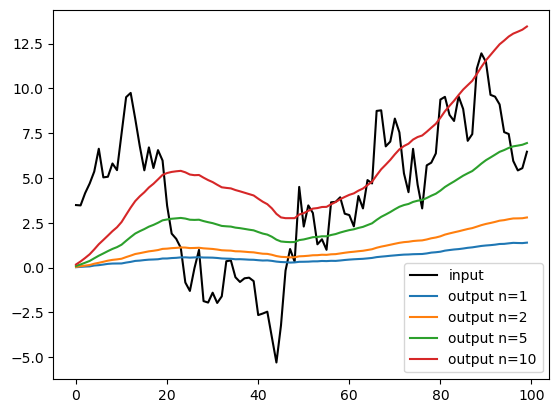

In [23]:
input_model = InputModel(birth=100.0, death=1.0, dt=1e-2, rngs=nnx.Rngs(2))
logp_s, s = input_model(jnp.empty((1, 100)), generate=True)

plt.plot(s[0], label="input", color="black")

for n in [1, 2, 5, 10]:
    output_model = NonlinearModel(rho=200.0, mu=1.0, n=n, K=100.0, dt=1e-2, rngs=nnx.Rngs(2))
    _, x = output_model(s, jnp.zeros((10000, 100)), generate=True)
    plt.plot(jnp.mean(x, axis=0), label=f"output n={n}")
plt.legend()

In [24]:
def log_conditional(output_model, s: jax.Array, x: jax.Array):
    s = jnp.atleast_2d(s)
    x = jnp.atleast_2d(x)
    out_state = output_model.initial_state(s, x, generate=False)

    def step(out_state, val: tuple[jax.Array, jax.Array]):
        out_state, _ = output_model.step(out_state, val)
        return out_state, out_state[1]
    
    return jax.lax.scan(step, out_state, (s.T, x.T))[1].T

In [178]:
def resample_state(inp_state, log_weights):
    key, _ = random.split(inp_state[0])
    resampled_indices = random.categorical(key, log_weights, shape=log_weights.shape)
    return jax.tree.map(
        lambda x: x[resampled_indices] if len(x.shape) > 0 else x, inp_state
    )


def smc_estimate(input_model, output_model, x: jax.Array, n_particles=128):
    def smc_run(models, _, x):
        input_model, output_model = models
        x = jnp.atleast_2d(x)
        s = jnp.zeros((n_particles,) + x.shape[1:])
        inp_state = input_model.initial_state(s, generate=True)
        out_state = output_model.initial_state(s, x, generate=False)

        def step(carry: tuple, s, x):
            (input_model, output_model), inp_state, out_state = carry

            inp_state, s = input_model.step(inp_state, s)
            (o1, log_weights, *rest), _ = output_model.step(out_state, (s, x))
            log_marginal_estimate = jax.nn.logsumexp(log_weights) - jnp.log(n_particles)
            ess = 1 / jnp.sum(jax.nn.softmax(log_weights) ** 2) / n_particles

            # resample if needed
            inp_state = jax.lax.cond(
                ess < 0.5,
                resample_state,
                lambda state, _: state,
                inp_state,
                log_weights,
            )
            # all weights need to be readjusted when we resample
            log_weights = jax.lax.cond(
                ess < 0.5,
                lambda log_weights, x: log_weights.at[:].set(x),
                lambda log_weights, _: log_weights,
                log_weights,
                log_marginal_estimate,
            )

            return ((input_model, output_model), inp_state, (o1, log_weights, *rest)), (log_marginal_estimate, ess)

        result = nnx.scan(step, in_axes=(nnx.Carry, 1, 1))((models, inp_state, out_state), s, x)
    
        return None, result[-1]
    models = (input_model, output_model)
    state_axes = nnx.StateAxes({nnx.RngState: None, ...: nnx.Carry})

    return nnx.scan(smc_run, in_axes=(state_axes, nnx.Carry, 0), out_axes=(nnx.Carry, 0))(models, None, x)[1]

In [179]:
def mutual_information(
    input_model, output_model, num_steps=500, dt=1e-2, mc_samples=1000, n_particles=1024
):
    _, s = input_model(jnp.zeros((mc_samples, num_steps)), generate=True)
    _, x = output_model(s, jnp.zeros((mc_samples, num_steps)), generate=True)

    log_c = log_conditional(output_model, s, x)
    log_m, ess = smc_estimate(input_model, output_model, x, n_particles=n_particles)
    time = np.arange(1, 1 + num_steps) * dt
    mi = np.asarray(jnp.mean(log_c - log_m, axis=0))
    variance = np.asarray(jnp.var(log_c - log_m, axis=0))
    return pl.DataFrame(
        {
            "Time": time,
            "MutualInformation": mi,
            "Variance": variance,
            "Count": mc_samples,
            "SEM": np.sqrt(variance / mc_samples),
            "n_particles": n_particles,
        }
    )

In [180]:
def run_simulation(kappa, tau, gain, dt, **kwargs):
    input_model = InputModel(birth=kappa, death=1.0, dt=dt, rngs=nnx.Rngs(1))
    output_model = NonlinearModel(
        rho=2 * kappa / tau, mu=1 / tau, n=2 * gain, K=kappa, dt=dt, rngs=nnx.Rngs(2)
    )
    df = mutual_information(input_model, output_model, dt=dt, **kwargs)
    return df.with_columns(gain=gain, kappa=kappa, tau=tau)

In [181]:
df = run_simulation(100.0, 2.0, 1.0, 1e-2, num_steps=500, mc_samples=2048)

In [15]:
df

Time,MutualInformation,Variance,Count,SEM,n_particles,gain,kappa,tau
f64,f32,f32,i32,f32,i32,f64,f64,f64
0.01,0.002683,0.00252,2048,0.001109,1024,1.0,100.0,2.0
0.02,0.006578,0.005393,2048,0.001623,1024,1.0,100.0,2.0
0.03,0.006513,0.008063,2048,0.001984,1024,1.0,100.0,2.0
0.04,0.007853,0.010628,2048,0.002278,1024,1.0,100.0,2.0
0.05,0.008335,0.012699,2048,0.00249,1024,1.0,100.0,2.0
…,…,…,…,…,…,…,…,…
4.96,0.580567,1.026417,2048,0.022387,1024,1.0,100.0,2.0
4.97,0.583824,1.029399,2048,0.02242,1024,1.0,100.0,2.0
4.98,0.586188,1.032521,2048,0.022454,1024,1.0,100.0,2.0


In [13]:
for gain in np.linspace(0, 20, 10):
    df = run_simulation(100.0, 2.0, gain, 1e-2, num_steps=500, mc_samples=2048)
    data.append(df)

NameError: name 'data' is not defined

In [150]:
pl.concat(data).write_csv("nonlinear-data.csv")

gain,dMI,dt
f64,f32,f64
0.0,0.0,3.0
0.097561,0.003047,3.0
0.195122,0.013725,3.0
0.292683,0.031881,3.0
0.390244,0.057247,3.0
…,…,…
11.111111,5.732131,3.0
13.333333,6.246679,3.0
15.555556,6.65412,3.0


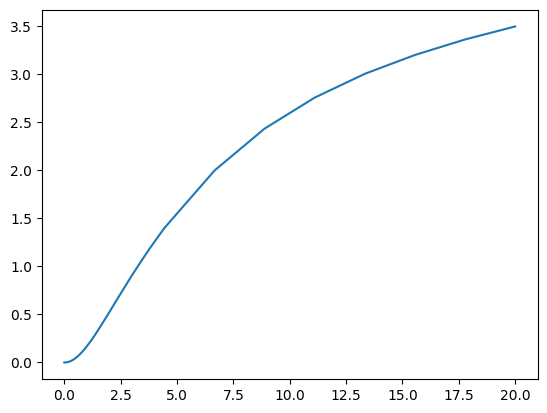

In [153]:
rates = pl.concat(data).filter(pl.col("Time") >= 2.0).group_by("gain", maintain_order=True).agg(
    (pl.col("MutualInformation").last() - pl.col("MutualInformation").first()).alias("dMI"),
    (pl.col("Time").last() - pl.col("Time").first()).alias("dt"),
).sort(by="gain")
plt.plot(rates["gain"], rates["dMI"] / rates["dt"] / np.log(2))
rates

In [148]:
rates["dMI"] / rates["dt"] / np.log(2)

dMI
f64
0.0
0.001465
0.006601
0.015331
0.02753
…
1.123697
1.157754
1.191248


In [5]:
class GRUCell(nnx.Module):
    def __init__(
        self,
        in_features: int,
        hidden_size: int,
        rngs: nnx.Rngs,
        kernel_init=nnx.initializers.lecun_normal(),
        recurrent_kernel_init=nnx.initializers.orthogonal(),
    ):
        self.hidden_size = hidden_size
        self.linear_ir = nnx.Linear(
            in_features, hidden_size, use_bias=True, kernel_init=kernel_init, rngs=rngs
        )
        self.linear_iz = nnx.Linear(
            in_features, hidden_size, use_bias=True, kernel_init=kernel_init, rngs=rngs
        )
        self.linear_in = nnx.Linear(
            in_features, hidden_size, use_bias=True, kernel_init=kernel_init, rngs=rngs
        )
        self.linear_hr = nnx.Linear(
            hidden_size,
            hidden_size,
            use_bias=False,
            kernel_init=recurrent_kernel_init,
            rngs=rngs,
        )
        self.linear_hz = nnx.Linear(
            hidden_size,
            hidden_size,
            use_bias=False,
            kernel_init=recurrent_kernel_init,
            rngs=rngs,
        )
        self.linear_hn = nnx.Linear(
            hidden_size,
            hidden_size,
            use_bias=True,
            kernel_init=recurrent_kernel_init,
            rngs=rngs,
        )

    def __call__(self, h: jax.Array, x: jax.Array):
        r = jax.nn.sigmoid(self.linear_ir(x) + self.linear_hr(h))
        z = jax.nn.sigmoid(self.linear_iz(x) + self.linear_hz(h))
        n = jax.nn.tanh(self.linear_in(x) + r * self.linear_hn(h))
        h = (1.0 - z) * n + z * h
        return h, h

    def initial_state(self, batch_size: int):
        return jnp.zeros((batch_size, self.hidden_size))


class RNN(nnx.Module):
    def __init__(self, cell, reverse=False):
        self.reverse = reverse
        self.cell = cell

    def __call__(self, x: jax.Array, *args, return_carry=False):
        def scan_fn(carry: jax.Array, cell: GRUCell, x: jax.Array, *args):
            return cell(carry, x, *args)

        carry = self.cell.initial_state(x.shape[0])
        carry, y = nnx.scan(
            scan_fn, state_axes={}, in_axes=1, out_axes=1, reverse=self.reverse
        )(carry, self.cell, x, *args)

        if return_carry:
            return carry, y
        else:
            return y


def shift_right(x: jax.Array, axis=1):
    pad_widths = [(0, 0)] * len(x.shape)
    pad_widths[axis] = (1, 0)
    ind = [slice(None)] * len(x.shape)
    ind[axis] = slice(-1)
    return jnp.pad(x, pad_widths)[tuple(ind)]


def logistic_logpdf(x, mean, log_scale):
    z = (x - mean) * jnp.exp(-log_scale)
    z_half = z / 2
    return -2 * jnp.logaddexp(z_half, -z_half) - log_scale


def logistic_logcdf(x, mean, log_scale):
    z = (x - mean) * jnp.exp(-log_scale)
    return jax.nn.log_sigmoid(z)


def mixlogistic_logpdf(x, prior_logits, means, log_scales):
    x = jnp.expand_dims(x, -1)
    log_pi = jax.nn.log_softmax(prior_logits, axis=-1)
    return jax.nn.logsumexp(log_pi + logistic_logpdf(x, means, log_scales), axis=-1)


def mixlogistic_logcdf(x, prior_logits, means, log_scales):
    x = jnp.expand_dims(x, -1)
    log_pi = jax.nn.log_softmax(prior_logits, axis=-1)
    return jax.nn.logsumexp(log_pi + logistic_logcdf(x, means, log_scales), axis=-1)


# coupling function from flow++
def coupling_function(x: jax.Array, pi: jax.Array, mu: jax.Array, log_s: jax.Array):
    # clipping is needed for numerical stability
    log_cdf = jnp.clip(mixlogistic_logcdf(x, pi, mu, log_s), a_max=-1e-12)
    # inverse sigmoid, i.e. logit(exp(log_cdf))
    val = log_cdf - jnp.log(-jnp.expm1(log_cdf))

    log_jac = mixlogistic_logpdf(x, pi, mu, log_s)
    # manually evaluate derivative log(1/(exp(log_cdf)*(1 - exp(log_cdf))))
    log_jac += -log_cdf - jnp.log(-jnp.expm1(log_cdf))
    return val, log_jac


class DecoderCell(nnx.Module):
    def __init__(
        self,
        in_features: int,
        hidden_size: int,
        rngs: nnx.Rngs,
        mixture_components: int = 5,
    ):
        self.cell = GRUCell(in_features, hidden_size, rngs=rngs)
        self.shift = nnx.Linear(hidden_size, 1, rngs=rngs)
        self.log_scale = nnx.Linear(hidden_size, 1, rngs=rngs)
        self.pi = nnx.Linear(hidden_size, mixture_components, rngs=rngs)
        self.mu = nnx.Linear(hidden_size, mixture_components, rngs=rngs)
        self.log_s = nnx.Linear(hidden_size, mixture_components, rngs=rngs)

    def __call__(self, carry, input, rngs: nnx.Rngs):
        rnn_state, last_prediction, logp = carry
        input = input.at[..., 0].set(last_prediction)

        rnn_state, y = self.cell(rnn_state, input)

        shift = jnp.squeeze(self.shift(y), -1)
        log_scale = jnp.squeeze(self.log_scale(y), -1)
        pi = self.pi(y)
        mu = self.mu(y)
        log_s = self.log_s(y)

        epsilon = random.logistic(rngs(), shape=y.shape[:-1])

        val, log_jac = coupling_function(epsilon, pi, mu, log_s)
        prediction = shift + val * jnp.exp(log_scale)

        logp += jax.scipy.stats.logistic.logpdf(epsilon) - log_scale - log_jac

        return (rnn_state, prediction, logp), prediction

    def initial_state(self, batch_size: int):
        cell_state = self.cell.initial_state(batch_size)
        initial_prediction = jnp.zeros(batch_size)
        logp = jnp.zeros(batch_size)
        return (cell_state, initial_prediction, logp)

In [62]:
class VariationalRnn(nnx.Module):
    def __init__(self, hidden_size: int, mixture_components: int, rngs: nnx.Rngs):
        self.rngs = rngs
        self.encoder_x = RNN(GRUCell(1, hidden_size, rngs=rngs), reverse=True)
        self.decoder_rnn = RNN(
            DecoderCell(
                1 + hidden_size,
                hidden_size,
                rngs=rngs,
                mixture_components=mixture_components,
            )
        )

    def __call__(self, s: jax.Array, x: jax.Array, rngs=None):
        # s, x: Make input tensors of shape [batch_size, seq_length, 1]
        s = s.reshape((-1, s.shape[-1]) + (1,))
        x = x.reshape((-1, x.shape[-1]) + (1,))

        # apply reverse rnn to x
        h_x = self.encoder_x(x)

        rngs = self.rngs if rngs is None else rngs

        h_x = jnp.broadcast_to(h_x, s.shape[:-1] + (h_x.shape[-1],))
        s_with_context = jnp.concatenate((s, h_x), axis=-1)
        (_, _, logp), preds = self.decoder_rnn(s_with_context, rngs, return_carry=True)

        return logp, preds

In [63]:
@dataclasses.dataclass
class CombinedModel(nnx.Module):
    prior: nnx.Module
    forward: nnx.Module
    backward: nnx.Module

    def importance_weight(self, x):
        s = jnp.empty_like(x)
        logq_s, preds = self.backward(s, x)
        logp_s = self.prior(preds)
        logp_x_given_s = self.forward(preds, x)
        return logp_s + logp_x_given_s - logq_s

    def elbo(self, x, num_samples=1):
        inner = lambda mod: mod.importance_weight(x)
        return nnx.vmap(inner, state_axes={}, out_axes=1, axis_size=num_samples)(self)

    @nnx.jit
    def conditional_probability(self, s, x):
        return self.forward(s, x)

    @nnx.jit
    def marginal_probability(self, x, N=2**14):
        x = jnp.reshape(x, (-1, x.shape[-1]))

        def log_p(carry, mod, x):
            log_weights = mod.elbo(x, num_samples=N)
            ess = 1 / jnp.sum(jax.nn.softmax(log_weights, axis=1) ** 2) / N
            logp = jax.nn.logsumexp(log_weights, axis=1) - jnp.log(N)
            return None, (logp, ess)

        _, (logp, ess) = nnx.scan(log_p, state_axes={})(None, self, x)
        return jnp.squeeze(logp, 1), ess

In [67]:
class TrainerModule:
    def __init__(self, model, logdir=None):
        self.model = model
        self.logdir = logdir
        self.create_functions()

    @staticmethod
    def forward_loss(model, s, x):
        loss = -model(s, x)
        return jnp.mean(loss), {"loss": loss}

    @staticmethod
    def backward_loss(model, x, subsample=1):
        elbo = model.elbo(x, num_samples=subsample)
        loss = -jnp.mean(elbo)
        return loss, {"elbo": elbo}

    def create_functions(self):
        def train_step_forward(model, optimizer, s_batch, x_batch):
            grad_fn = nnx.value_and_grad(self.forward_loss, has_aux=True)
            (loss, metrics), grads = grad_fn(model, s_batch, x_batch)
            optimizer.update(grads=grads)
            return loss, metrics

        self.train_step_forward = nnx.jit(train_step_forward)

        def train_step_backward(model, optimizer, x, subsample=1):
            grad_fn = nnx.value_and_grad(
                self.backward_loss, has_aux=True, wrt=optimizer.wrt
            )
            (loss, metrics), grads = grad_fn(model, x, subsample)
            optimizer.update(grads=grads)
            return loss, metrics

        self.train_step_backward = nnx.jit(
            train_step_backward, static_argnames="subsample"
        )

    def train_forward_model(
        self, key, s, x, num_steps=500, batch_size=64, learning_rate=1e-2
    ):
        num_samples = s.shape[0]
        schedule = optax.cosine_decay_schedule(
            learning_rate, num_steps * len(range(0, num_samples, batch_size)), alpha=0.1
        )
        optimizer = nnx.Optimizer(self.model.forward, optax.adamw(schedule))

        AverageLoss = metrics.Average.from_output("loss")
        if self.logdir is not None:
            writer = metric_writers.create_default_writer(
                os.path.join(self.logdir, "Forward")
            )
        else:
            writer = metric_writers.LoggingWriter()

        for epoch in range(num_steps):
            epoch_key = random.fold_in(key, epoch)
            perm = random.permutation(epoch_key, num_samples)
            s_shuffle = s[perm]
            x_shuffle = x[perm]

            average_loss = AverageLoss.empty()
            for j in range(0, num_samples, batch_size):
                s_batch = s_shuffle[j : j + batch_size]
                x_batch = x_shuffle[j : j + batch_size]
                loss, train_metrics = self.train_step_forward(
                    self.model.forward, optimizer, s_batch, x_batch
                )
                average_loss = average_loss.merge(
                    AverageLoss.from_model_output(loss=train_metrics["loss"])
                )
            scalars = {
                "loss": average_loss.compute(),
                "learning rate": schedule(optimizer.step.value),
            }
            if writer is not None:
                writer.write_scalars(epoch + 1, scalars)

    def train_backward_model(
        self,
        key,
        x: jax.Array,
        num_steps=500,
        batch_size=64,
        subsample=16,
        learning_rate=5e-3,
    ):
        num_samples = x.shape[0]

        # only optimize parameters of backward model
        backward_filter = nnx.All(nnx.Param, lambda path, val: "backward" in path)

        schedule = optax.exponential_decay(
            learning_rate, num_steps * len(range(0, num_samples, batch_size)), 0.5
        )

        optimizer = nnx.Optimizer(self.model, optax.adamw(schedule), backward_filter)

        AverageLoss = metrics.Average.from_output("loss")
        if self.logdir is not None:
            writer = metric_writers.create_default_writer(
                os.path.join(self.logdir, "Backward")
            )
        else:
            writer = metric_writers.LoggingWriter()

        for epoch in range(num_steps):
            epoch_key = random.fold_in(key, epoch)
            perm = random.permutation(epoch_key, num_samples)
            x_shuffle = x[perm]

            average_loss = AverageLoss.empty()
            for j in range(0, num_samples, batch_size):
                x_batch = x_shuffle[j : j + batch_size]
                _, train_metrics = self.train_step_backward(
                    self.model, optimizer, x_batch, subsample=subsample
                )
                average_loss = average_loss.merge(
                    AverageLoss.from_model_output(loss=-train_metrics["elbo"])
                )
            scalars = {
                "loss": average_loss.compute(),
                "learning rate": schedule(optimizer.step.value),
            }
            if writer is not None:
                writer.write_scalars(epoch + 1, scalars)
                # writer.write_histograms(epoch + 1, metrics)

    def mutual_information(self, length=50, sample_size=1000):
        _, s = self.model.prior(jnp.empty((sample_size, length)), generate=True)
        _, x = self.model.forward(s, jnp.empty_like(s), generate=True)

        cond = self.model.conditional_probability(s, x)
        marg, ess = self.model.marginal_probability(x)

        return cond - marg, ess

In [72]:
def run_simulation(rho=200.0, mu=1.0, n=1.0, K=100.0, length=500, dt=1e-2):
    input_model = InputModel(dt=dt, rngs=nnx.Rngs(1))
    output_model = NonlinearModel(rho=rho, mu=mu, n=n, K=K, dt=dt, rngs=nnx.Rngs(2))

    comb_model = CombinedModel(
        prior=input_model,
        forward=output_model,
        backward=VariationalRnn(64, 16, rngs=nnx.Rngs(3)),
        # backward=IAF(21, 256, 8, rngs=nnx.Rngs(3)),
    )

    sample_size = 1000

    _, s = input_model(jnp.empty((sample_size, length)), generate=True)
    _, x = output_model(s, jnp.empty_like(s), generate=True)

    trainer = TrainerModule(comb_model)
    trainer.train_backward_model(random.key(1), x, 100, subsample=1)

    data = []
    for length in [1] + list(range(100, length + 1, 100)):
        mi, ess = trainer.mutual_information(length=length, sample_size=sample_size)
        df = pl.DataFrame(
            {"mi": np.asarray(mi), "ess": np.asarray(ess), "length": length}
        )
        print(df.mean())
        data.append(df)
    return pl.concat(data)

In [73]:
data = run_simulation()

INFO:absl:[1] learning rate=0.004965462256222963, loss=1193.45556640625
INFO:absl:[2] learning rate=0.0049311635084450245, loss=993.423095703125
INFO:absl:[3] learning rate=0.004897101316601038, loss=927.5950927734375
INFO:absl:[4] learning rate=0.004863274749368429, loss=909.57861328125
INFO:absl:[5] learning rate=0.0048296814784407616, loss=903.1945190429688
INFO:absl:[6] learning rate=0.0047963205724954605, loss=899.8672485351562
INFO:absl:[7] learning rate=0.0047631897032260895, loss=896.843017578125
INFO:absl:[8] learning rate=0.004730288404971361, loss=894.8678588867188
INFO:absl:[9] learning rate=0.004697613418102264, loss=893.9513549804688
INFO:absl:[10] learning rate=0.004665164742618799, loss=892.8259887695312
INFO:absl:[11] learning rate=0.004632940050214529, loss=892.1744384765625
INFO:absl:[12] learning rate=0.004600937943905592, loss=891.3572387695312
INFO:absl:[13] learning rate=0.004569157492369413, loss=891.2001342773438
INFO:absl:[14] learning rate=0.00453759590163826

shape: (1, 3)
┌──────────┬──────────┬────────┐
│ mi       ┆ ess      ┆ length │
│ ---      ┆ ---      ┆ ---    │
│ f32      ┆ f32      ┆ f64    │
╞══════════╪══════════╪════════╡
│ 0.164149 ┆ 0.010749 ┆ 1.0    │
└──────────┴──────────┴────────┘
shape: (1, 3)
┌──────────┬──────────┬────────┐
│ mi       ┆ ess      ┆ length │
│ ---      ┆ ---      ┆ ---    │
│ f32      ┆ f32      ┆ f64    │
╞══════════╪══════════╪════════╡
│ 0.199592 ┆ 0.058217 ┆ 100.0  │
└──────────┴──────────┴────────┘
shape: (1, 3)
┌──────────┬──────────┬────────┐
│ mi       ┆ ess      ┆ length │
│ ---      ┆ ---      ┆ ---    │
│ f32      ┆ f32      ┆ f64    │
╞══════════╪══════════╪════════╡
│ 0.389045 ┆ 0.029837 ┆ 200.0  │
└──────────┴──────────┴────────┘
shape: (1, 3)
┌──────────┬──────────┬────────┐
│ mi       ┆ ess      ┆ length │
│ ---      ┆ ---      ┆ ---    │
│ f32      ┆ f32      ┆ f64    │
╞══════════╪══════════╪════════╡
│ 0.560225 ┆ 0.017419 ┆ 300.0  │
└──────────┴──────────┴────────┘
shape: (1, 3)
┌─────

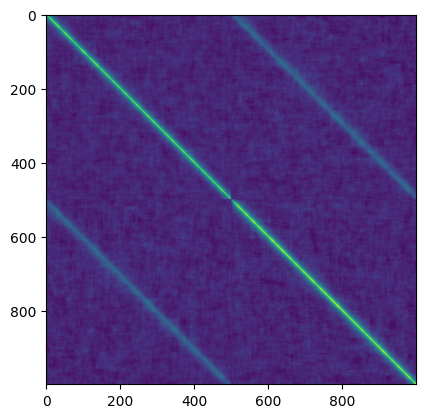

In [69]:
input_model = InputModel(birth=100.0, death=1.0, dt=1e-1, rngs=nnx.Rngs(1))
output_model = NonlinearModel(rho=200.0, mu=1.0, n=1.0, K=100.0, dt=1e-1, rngs=nnx.Rngs(2))

comb_model = CombinedModel(
    prior=input_model,
    forward=output_model,
    backward=VariationalRnn(64, 4, rngs=nnx.Rngs(3)),
    # backward=IAF(21, 256, 8, rngs=nnx.Rngs(3)),
)

sample_size = 1000
length = 500

_, s = input_model(jnp.empty((sample_size, length)), generate=True)
_, x = output_model(s, jnp.empty_like(s), generate=True)
plt.imshow(jnp.cov(s.T, x.T))

In [70]:
trainer = TrainerModule(comb_model)
trainer.train_backward_model(random.key(1), x, 100, subsample=16)

INFO:absl:[1] learning rate=0.004965462256222963, loss=1614.539306640625
INFO:absl:[2] learning rate=0.0049311635084450245, loss=1499.9095458984375
INFO:absl:[3] learning rate=0.004897101316601038, loss=1480.151123046875
INFO:absl:[4] learning rate=0.004863274749368429, loss=1471.991943359375
INFO:absl:[5] learning rate=0.0048296814784407616, loss=1468.475830078125
INFO:absl:[6] learning rate=0.0047963205724954605, loss=1466.4652099609375
INFO:absl:[7] learning rate=0.0047631897032260895, loss=1465.1888427734375
INFO:absl:[8] learning rate=0.004730288404971361, loss=1464.9024658203125
INFO:absl:[9] learning rate=0.004697613418102264, loss=1464.211669921875
INFO:absl:[10] learning rate=0.004665164742618799, loss=1463.5484619140625
INFO:absl:[11] learning rate=0.004632940050214529, loss=1463.48486328125
INFO:absl:[12] learning rate=0.004600937943905592, loss=1463.371337890625
INFO:absl:[13] learning rate=0.004569157492369413, loss=1462.8135986328125
INFO:absl:[14] learning rate=0.0045375

KeyboardInterrupt: 